# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 350000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (350000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [50]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [51]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [52]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [53]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [54]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [55]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [56]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(256438, 10)

In [57]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

73.268

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [58]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [59]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [60]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(256436, 10)


1    215863
0     40573
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [61]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with th

In [62]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with th

In [63]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with the occasional

In [64]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [65]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have five dogs and in this economy with so many people giving up their pets as they can not afford them, I decided to look for a still decent (not all byproduct and corn) but not expensive food and I found it.<br /><br />All my dogs love it, and I rotate between the other flavors too.<br /><br />I know its not top line and people can nitpick on some ingredients but for $30 with free delivery, its a great deal.


In [66]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy  children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with the oc

In [67]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have five dogs and in this economy with so many people giving up their pets as they can not afford them I decided to look for a still decent not all byproduct and corn but not expensive food and I found it br br All my dogs love it and I rotate between the other flavors too br br I know its not top line and people can nitpick on some ingredients but for 30 with free delivery its a great deal 


In [68]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [69]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 256436/256436 [02:02<00:00, 2091.22it/s]


In [70]:
preprocessed_reviews[100]

'great product dog loves see amazon lists sellers used new would not recommend buying used'

In [71]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [72]:
final['Text'] = preprocessed_reviews

In [73]:
#soring the values based on time stamp
final.sort_values('Time', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
final = final.drop(['ProductId','Id','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'],axis=1)


In [74]:
final.columns

Index(['Score', 'Text'], dtype='object')

In [77]:
do_pickling('final.pickle',final)

In [68]:
y = final['Score']
text = final['Text']

In [69]:
text.shape

(107309,)

In [70]:
# X_train_1, test_df_1, y_train_1, y_test_1 = train_test_split(final, y, stratify=y, test_size=0.7)
# print(X_train_1.shape)
# print(y_train_1.shape)

X_train, test_df, y_train, y_test = train_test_split(text, y, stratify=y, test_size=0.2)
train_df, cv_df, y, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

print(train_df.shape)
print(y.shape)
print(cv_df.shape)
print(y_cv.shape)

(68677,)
(68677,)
(17170,)
(17170,)


In [71]:
print(np.unique(y_train))
print(np.unique(y_test))
print(np.unique(y_cv))

[0 1]
[0 1]
[0 1]


In [76]:
def do_pickling(filename,data):
    with open(filename, "wb") as f:
        pickle.dump(data,f)

In [73]:
do_pickling('y_train.pickle',y)
do_pickling('y_test.pickle',y_test)
do_pickling('y_cv.pickle',y_cv)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [139]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


In [40]:
count_vect = CountVectorizer(ngram_range=(1,3),min_df=10)
bow_feature_train = count_vect.fit_transform(train_df)
bow_feature_test = count_vect.transform(test_df)
bow_feature_cv = count_vect.transform(cv_df)

In [41]:
bow_feature_train.shape

(68677, 114137)

In [42]:
do_pickling('bow_train.pickle',bow_feature_train)
do_pickling('bow_test.pickle',bow_feature_test)
do_pickling('bow_cv.pickle',bow_feature_cv)
do_pickling('count_vect.pickle',count_vect)

## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


In [46]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3),min_df=10)
tf_idf_train = tf_idf_vect.fit_transform(train_df)
tf_idf_test = tf_idf_vect.transform(test_df)
tf_idf_cv = tf_idf_vect.transform(cv_df)

In [47]:
tf_idf_train.shape

(68677, 114137)

In [48]:
do_pickling('tfidf_train.pickle',tf_idf_train)
do_pickling('tfidf_test.pickle',tf_idf_test)
do_pickling('tfidf_cv.pickle',tf_idf_cv)
do_pickling('tf_idf_vect.pickle',tf_idf_vect)

## [4.4] Word2Vec

In [140]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [141]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8430249691009521), ('awesome', 0.8368998169898987), ('terrific', 0.828173041343689), ('good', 0.8232675790786743), ('excellent', 0.8207688927650452), ('wonderful', 0.7675489783287048), ('perfect', 0.7497045397758484), ('nice', 0.7258481979370117), ('amazing', 0.7052987217903137), ('fabulous', 0.6872046589851379)]
[('greatest', 0.8145409226417542), ('tastiest', 0.7404407858848572), ('best', 0.7321152091026306), ('nastiest', 0.7277255654335022), ('vile', 0.6806230545043945), ('disgusting', 0.6788105964660645), ('closest', 0.6277113556861877), ('terrible', 0.6277025938034058), ('horrible', 0.627235472202301), ('wins', 0.6269370913505554)]


In [142]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  19146
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'plant', 'work', 'well', 'decided', 'repot', 'larger', 'pot', 'must', 'gotten', 'funky', 'soil', 'soon', 'repotted', 'large', 'colony', 'small', 'flies', 'getting']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [74]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

NameError: name 'list_of_sentance' is not defined

In [76]:
def findAvgWord2Vec(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors
    

In [77]:
def getListOfSentences(values):
    list_of_sent=[]
    for sent in values:
        list_of_sent.append(sent.split())
    return list_of_sent

In [78]:
list_of_sent = getListOfSentences(train_df.values)
w2v_model=Word2Vec(list_of_sent,min_count=10,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [79]:
sent_vectors_train = findAvgWord2Vec(list_of_sent)

100%|██████████| 68677/68677 [02:18<00:00, 497.54it/s]


In [80]:
do_pickling('avg_w2v_train.pickle',sent_vectors_train)

In [81]:
list_of_sent = getListOfSentences(test_df.values)

In [82]:
sent_vectors_test = findAvgWord2Vec(list_of_sent)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 21462/21462 [00:40<00:00, 533.41it/s]

21462
50


In [83]:
do_pickling('avg_w2v_test.pickle',sent_vectors_test)

In [84]:
list_of_sent= getListOfSentences(cv_df.values)
sent_vectors_cv = findAvgWord2Vec(list_of_sent)

100%|██████████| 17170/17170 [00:35<00:00, 481.82it/s]


In [86]:
do_pickling('avg_w2v_cv.pickle',sent_vectors_cv)

#### [4.4.1.2] TFIDF weighted W2v

In [160]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


In [89]:
def findTfidfW2V(values):
    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(values)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    
    list_of_sent=[]
    for sent in values:
        list_of_sent.append(sent.split())
        
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                if(len(word)!=1):
                    vec = w2v_model.wv[word]
                    # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                    # to reduce the computation we are 
                    # dictionary[word] = idf value of word in whole courpus
                    # sent.count(word) = tf valeus of word in this review
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [90]:
tfidf_sent_vectors = findTfidfW2V(train_df)
print(len(tfidf_sent_vectors))

100%|██████████| 68677/68677 [02:28<00:00, 461.96it/s]

68677


In [122]:
do_pickling('tfidf_w2v_train.pickle',tfidf_sent_vectors)

In [91]:
tfidf_sent_vectors_test = findTfidfW2V(test_df.values)
print(len(tfidf_sent_vectors_test))

100%|██████████| 21462/21462 [00:44<00:00, 478.64it/s]

21462


In [92]:
do_pickling('tfidf_w2v_test.pickle',tfidf_sent_vectors_test)

In [93]:
tfidf_sent_vectors_cv = findTfidfW2V(cv_df.values)

100%|██████████| 17170/17170 [00:46<00:00, 366.59it/s]


In [127]:
do_pickling('tfidf_w2v_cv.pickle',tfidf_sent_vectors_cv)

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

In [99]:
import sqlite3
import pandas as pd
import numpy as np

import pickle 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score,roc_curve
from wordcloud import WordCloud
from sklearn import tree
from sklearn.metrics import f1_score
import graphviz 

In [100]:
# function to load the pickle data
def loadPickleData(filename):
    pickle_off = open(filename,"rb")
    final = pickle.load(pickle_off)
    return final


In [101]:
# load the y values because they are common across all feature engineering
y_train = loadPickleData('y_train.pickle')
y_test = loadPickleData('y_test.pickle')
y_cv = loadPickleData('y_cv.pickle')

In [102]:
# # Encode labels

# encoded_column_vector = label_binarize(y_train, classes=['negative','positive']) # ham will be 0 and spam will be 1
# y_train = np.ravel(encoded_column_vector)

# encoded_column_vector = label_binarize(y_test, classes=['negative','positive']) # ham will be 0 and spam will be 1
# y_test = np.ravel(encoded_column_vector)

# encoded_column = label_binarize(y_cv, classes=['negative','positive']) # ham will be 0 and spam will be 1
# y_cv = np.ravel(encoded_column)

In [103]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [104]:
def drawplots(auc_array,auc_array_train):
    fig, ax = plt.subplots(4,1,figsize=(12,12))
    a = np.arange(len(depth))
    l5 = [x for i,x in enumerate(auc_array) if i %4 ==0]
    l10 = [x for i,x in enumerate(auc_array) if i %4 ==1]
    l100 = [x for i,x in enumerate(auc_array) if i %4 ==2]
    l500 = [x for i,x in enumerate(auc_array) if i %4 ==3]

    l5_train = [x for i,x in enumerate(auc_array_train) if i %4 ==0]
    l10_train= [x for i,x in enumerate(auc_array_train) if i %4 ==1]
    l100_train = [x for i,x in enumerate(auc_array_train) if i %4 ==2]
    l500_train = [x for i,x in enumerate(auc_array_train) if i %4 ==3]

    ax[0].plot(a, l5,c='g',label="cv")
    for i, txt in enumerate(np.round(l5,3)):
        ax[0].annotate((a[i],str(txt)), (a[i],l5[i]))
    
    ax[0].plot(a, l5_train,c='r',label="train")
    for i, txt in enumerate(np.round(l5_train,3)):
        ax[0].annotate((a[i],str(txt)), (a[i],l5_train[i]),(a[i],l5_train[i]))
        
    ax[0].set_xticks(a)
    ax[0].set_xticklabels(depth)
    plt.grid()
    ax[0].set_title("Cross Validation AUC for each depth ")
    ax[0].set_xlabel("depth i's")
    ax[0].set_ylabel("AUC")
    
    ax[1].plot(a, l10,c='g',label="cv")   
    for i, txt in enumerate(np.round(l10,3)):
        ax[1].annotate((a[i],str(txt)), (a[i],l10[i]))
    
    ax[1].plot(a, l10_train,c='r',label="train")
    for i, txt in enumerate(np.round(l10_train,3)):
        ax[1].annotate((a[i],str(txt)), (a[i],l10_train[i]),(a[i],l10_train[i]))
        
    ax[1].set_xticks(a)
    ax[1].set_xticklabels(depth)
    plt.grid()
    ax[1].set_title("AUC ")
    ax[1].set_xlabel("depth i's")
    ax[1].set_ylabel("AUC")
    
    ax[2].plot(a, l100,c='g',label="cv")   
    for i, txt in enumerate(np.round(l100,3)):
        ax[2].annotate((a[i],str(txt)), (a[i],l100[i]))
    
    ax[2].plot(a, l100_train,c='r',label="train")
    for i, txt in enumerate(np.round(l100_train,3)):
        ax[2].annotate((a[i],str(txt)), (a[i],l100_train[i]),(a[i],l100_train[i]))
        
    ax[2].set_xticks(a)
    ax[2].set_xticklabels(depth)
    plt.grid()
    ax[2].set_title("AUC ")
    ax[2].set_xlabel("depth i's")
    ax[2].set_ylabel("AUC")
    
    ax[3].plot(a, l500,c='g',label="cv")
    for i, txt in enumerate(np.round(l5,3)):
        ax[3].annotate((a[i],str(txt)), (a[i],l5[i]))
    
    ax[3].plot(a, l500_train,c='r',label="train")
    for i, txt in enumerate(np.round(l500_train,3)):
        ax[3].annotate((a[i],str(txt)), (a[i],l500_train[i]),(a[i],l500_train[i]))
        
    ax[3].set_xticks(a)
    ax[3].set_xticklabels(depth)
    plt.grid()
    ax[3].set_title("Cross Validation AUC for each depth ")
    ax[3].set_xlabel("depth i's")
    ax[3].set_ylabel("AUC")
    
    plt.legend(loc='best')
    plt.subplots_adjust(left=None, bottom=0.1, right=None, top=3, wspace=None, hspace=None)
    plt.show()    

In [105]:
def plotAUC(train_fpr,train_tpr,test_fpr,test_tpr):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(train_fpr, train_tpr,c='g',label="cv")
    ax.plot(test_fpr, test_tpr,c='r',label="train")

    plt.grid()
    ax.set_title("ROC Curve")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")

In [106]:
def getImportantFeatures(indices,feature_names):
    words =[]
    for x in indices:
        words.append(feature_names[x])
    return words

In [107]:
def draw_wordcloud(train):
    wordcloud = WordCloud(    background_color='black',
                              width=1600,
                              height=800,
                        ).generate(train)

    fig = plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [108]:
def drawTree(clf,featureNames=None,classNames=None):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=featureNames, 
                      max_depth = 2,
                      class_names=classNames,  
                      filled=True, rounded=True,  
                      special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

In [109]:
# for cross validation
depth = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split = [5, 10, 100, 500]

In [110]:
def calculateMetricC(X,y,train,y_train):
    auc_array = []   
    for i in depth:
        for r in min_samples_split:
            print("for depth = {} and min_samples_split = {}".format(i,r))
            clf = tree.DecisionTreeClassifier(max_depth = i,min_samples_split = r)
            clf.fit(train, y_train)
            pred = clf.predict(X)
            area = roc_auc_score(y, pred)
            auc_array.append(area)
            print("Area:",area)
    return auc_array

In [111]:
def performHyperParameterTuning(train,cv,test):
    auc_array = []
    auc_array = calculateMetricC(cv,y_cv,train,y_train)
    #print(auc_array)
    auc_array_train = calculateMetricC(train,y_train,train,y_train)
    #print(auc_array_train)
    return (auc_array,auc_array_train)
#     clf = SGDClassifier(class_weight='balanced', alpha=best_a, penalty=best_r, loss='hinge', random_state=42)
#     clf.fit(train, y_train)
#     sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
#     sig_clf.fit(train, y_train)
    
#     predict_y = sig_clf.predict(train)
#     plot_confusion_matrix(y_train,predict_y)
#     print('For values of best alpha = ', alpha[int(best_alpha/2)], "The AUC is:",roc_auc_score(y_train, predict_y))
#     predict_y = sig_clf.predict(cv)
#     print('For values of best alpha = ', alpha[int(best_alpha/2)], "The cross validation fpr is:",roc_auc_score(y_cv, predict_y))
#     predict_y = sig_clf.predict(test)
#     plot_confusion_matrix(y_test,predict_y)
#     print('For values of best alpha = ', alpha[int(best_alpha/2)], "The test fpr is:",roc_auc_score(y_test, predict_y))
#     return clf,alpha[best_alpha]

In [112]:
def draw(auc_array,auc_array_train):
    drawplots(auc_array,auc_array_train)
    best_alpha = np.argmax(auc_array)
    best_a = depth[int(best_alpha/4)]
    best_r = min_samples_split[int(best_alpha%4)]
    print("best depth = {} and min_samples_split = {}".format(best_a,best_r))
    return (best_a,best_r)

In [113]:
def bestModel(train,cv,test,best_depth,best_samples_split):
    clf = tree.DecisionTreeClassifier(max_depth = best_depth,min_samples_split = best_samples_split)
    clf.fit(train, y_train)
    
    predict_y = clf.predict(train)
    plot_confusion_matrix(y_train,predict_y)
    train_fpr,train_tpr , train_thresholds = roc_curve(y_train, predict_y)
    print('For values of best alpha = ',best_depth, "The AUC is:",roc_auc_score(y_train, predict_y))
    predict_y = clf.predict(cv)
    print('For values of best alpha = ',best_depth, "The AUC is:",roc_auc_score(y_cv, predict_y))
    predict_y = clf.predict(test)
    plot_confusion_matrix(y_test,predict_y)
    test_fpr,test_tpr ,train_thresholds = roc_curve(y_test, predict_y)
    print('For values of best alpha = ',best_depth, "The AUC is:",roc_auc_score(y_test, predict_y))
    plotAUC(train_fpr,train_tpr,test_fpr,test_tpr)
    return clf

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [60]:
train = loadPickleData("bow_train.pickle")
test = loadPickleData('bow_test.pickle')
cv = loadPickleData('bow_cv.pickle')

In [61]:
count_vect = loadPickleData('count_vect.pickle')

In [62]:
auc_array,auc_array_train = performHyperParameterTuning(train,cv,test)

for depth = 1 and min_samples_split = 5
Area: 0.5
for depth = 1 and min_samples_split = 10
Area: 0.5
for depth = 1 and min_samples_split = 100
Area: 0.5
for depth = 1 and min_samples_split = 500
Area: 0.5
for depth = 5 and min_samples_split = 5
Area: 0.563125459348403
for depth = 5 and min_samples_split = 10
Area: 0.5629434426028624
for depth = 5 and min_samples_split = 100
Area: 0.5629434426028624
for depth = 5 and min_samples_split = 500
Area: 0.5660291078887696
for depth = 10 and min_samples_split = 5
Area: 0.5858343294006123
for depth = 10 and min_samples_split = 10
Area: 0.5849155631851515
for depth = 10 and min_samples_split = 100
Area: 0.5846815146125386
for depth = 10 and min_samples_split = 500
Area: 0.5903415248987626
for depth = 50 and min_samples_split = 5
Area: 0.7037573415292653
for depth = 50 and min_samples_split = 10
Area: 0.7014084257132784
for depth = 50 and min_samples_split = 100
Area: 0.704225438674491
for depth = 50 and min_samples_split = 500
Area: 0.71003254645

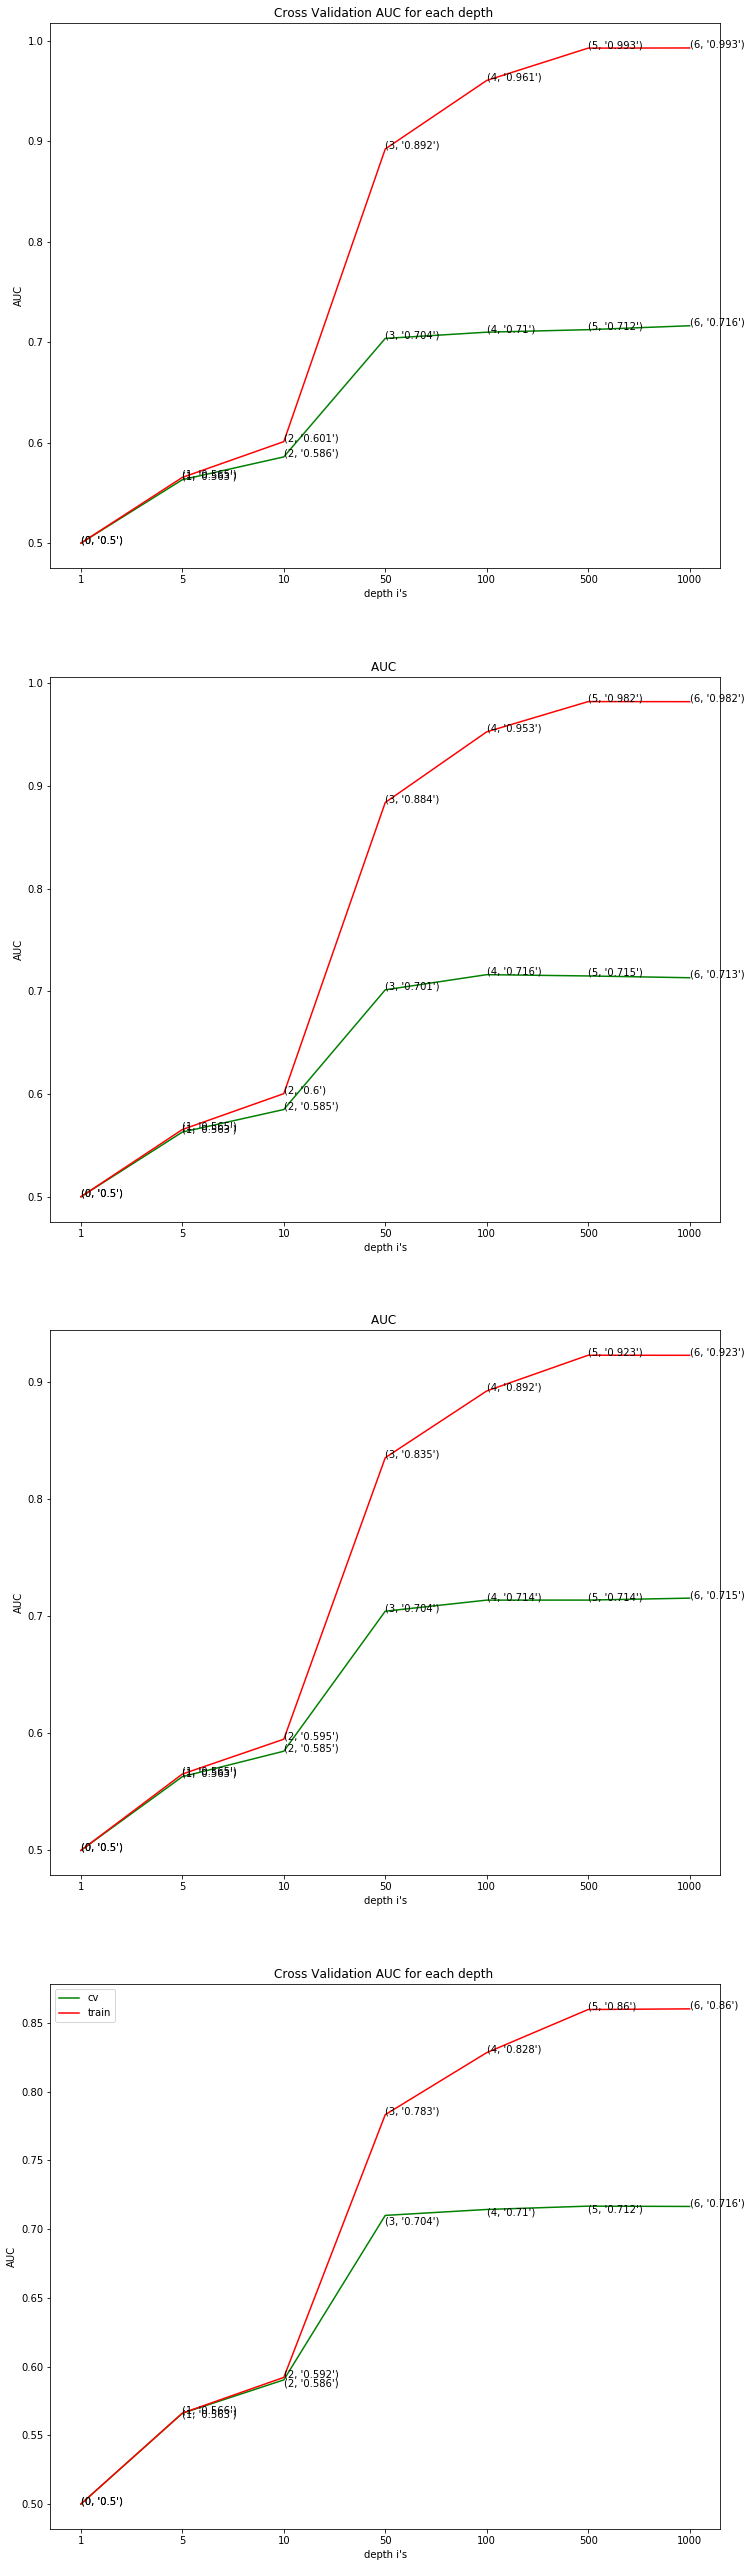

best depth = 500 and min_samples_split = 500


In [63]:
best_depth,best_samples_split = draw(auc_array,auc_array_train)

-------------------- Confusion matrix --------------------


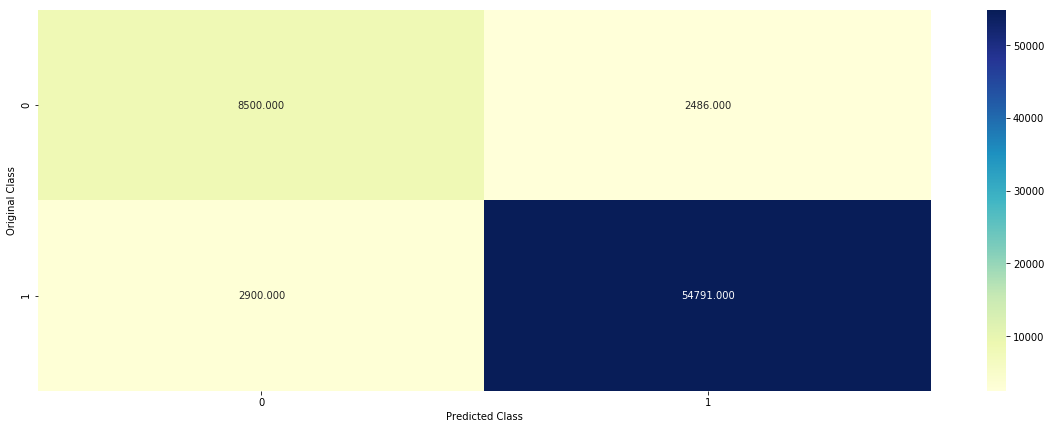

For values of best alpha =  500 The AUC is: 0.8617220955084656
For values of best alpha =  500 The AUC is: 0.7164215071178354
-------------------- Confusion matrix --------------------


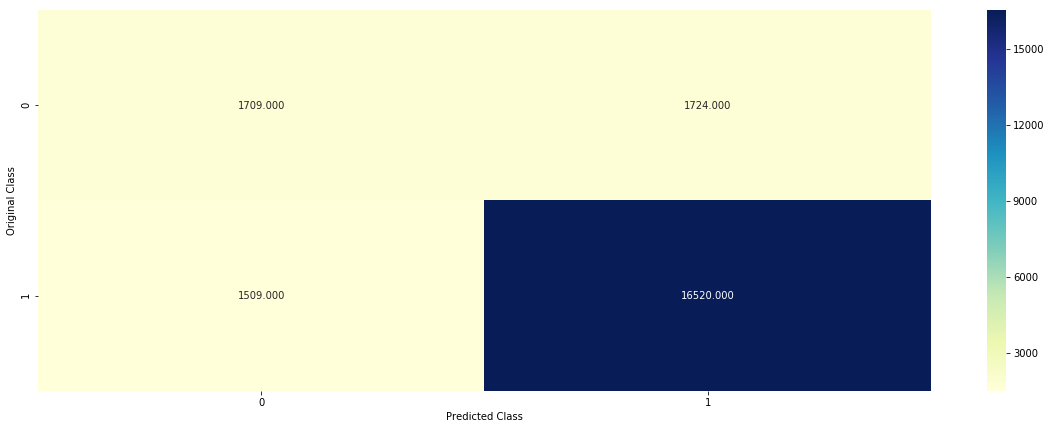

For values of best alpha =  500 The AUC is: 0.7070584180514944


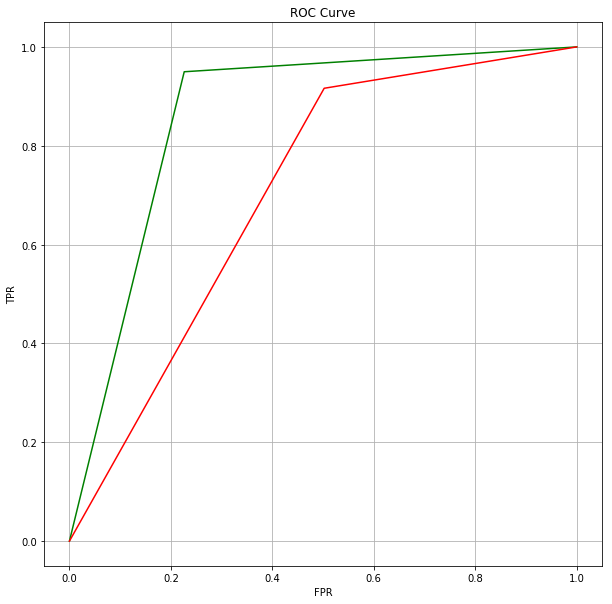

In [64]:
clf = bestModel(train,cv,test,best_depth,best_samples_split)

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [81]:
feature_names = count_vect.get_feature_names()
indices = np.argsort(-clf.feature_importances_)
word_indices = indices[-10:]
word_list = getImportantFeatures(word_indices,feature_names)
print(word_list)

['good could', 'good cookies', 'good cookie', 'good consistency', 'good considering', 'good conscience', 'good condition the', 'good condition and', 'good customer service', 'zukes']


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [82]:
word_indices = indices[:10]
word_list = getImportantFeatures(word_indices,feature_names)
print(word_list)

['not', 'great', 'worst', 'disappointed', 'awful', 'not buy', 'very disappointed', 'money', 'the best', 'threw']


### [5.1.3] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [83]:
n_nodes = clf.tree_.node_count
print(n_nodes)

3807


In [84]:
# words in each node of decision tree
feature = clf.tree_.feature
words = getImportantFeatures(feature,feature_names)
print(len(words))

3807


In [85]:
print(words[:20])

['not', 'worst', 'disappointed', 'awful', 'threw', 'horrible', 'great', 'terrible', 'disappointing', 'bad', 'waste', 'disgusting', 'disappointment', 'return', 'save your', 'love', 'the best', 'never buy', 'delicious', 'good']


In [86]:
graph = drawTree(clf,feature_names)

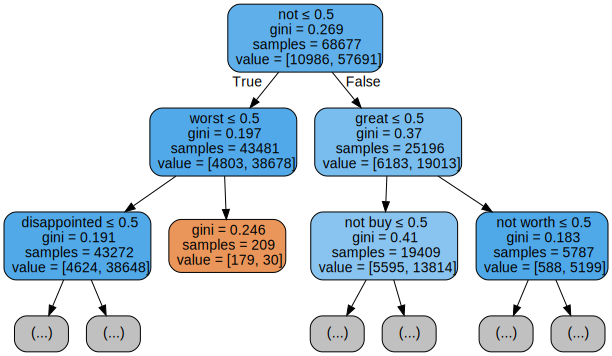

In [87]:
graph

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [88]:
train = loadPickleData("tfidf_train.pickle")
test = loadPickleData('tfidf_test.pickle')
cv = loadPickleData('tfidf_cv.pickle')

In [89]:
tf_idf_vect = loadPickleData('tf_idf_vect.pickle')

In [90]:
auc_array,auc_array_train = performHyperParameterTuning(train,cv,test)

for depth = 1 and min_samples_split = 5
Area: 0.5
for depth = 1 and min_samples_split = 10
Area: 0.5
for depth = 1 and min_samples_split = 100
Area: 0.5
for depth = 1 and min_samples_split = 500
Area: 0.5
for depth = 5 and min_samples_split = 5
Area: 0.5843958759091783
for depth = 5 and min_samples_split = 10
Area: 0.5845778926547188
for depth = 5 and min_samples_split = 100
Area: 0.5841791923120812
for depth = 5 and min_samples_split = 500
Area: 0.5860167247430028
for depth = 10 and min_samples_split = 5
Area: 0.6204092702618913
for depth = 10 and min_samples_split = 10
Area: 0.619377821004003
for depth = 10 and min_samples_split = 100
Area: 0.6231395214450002
for depth = 10 and min_samples_split = 500
Area: 0.629189738884529
for depth = 50 and min_samples_split = 5
Area: 0.6928365260952549
for depth = 50 and min_samples_split = 10
Area: 0.6948820596355156
for depth = 50 and min_samples_split = 100
Area: 0.7031943680134527
for depth = 50 and min_samples_split = 500
Area: 0.71614373060

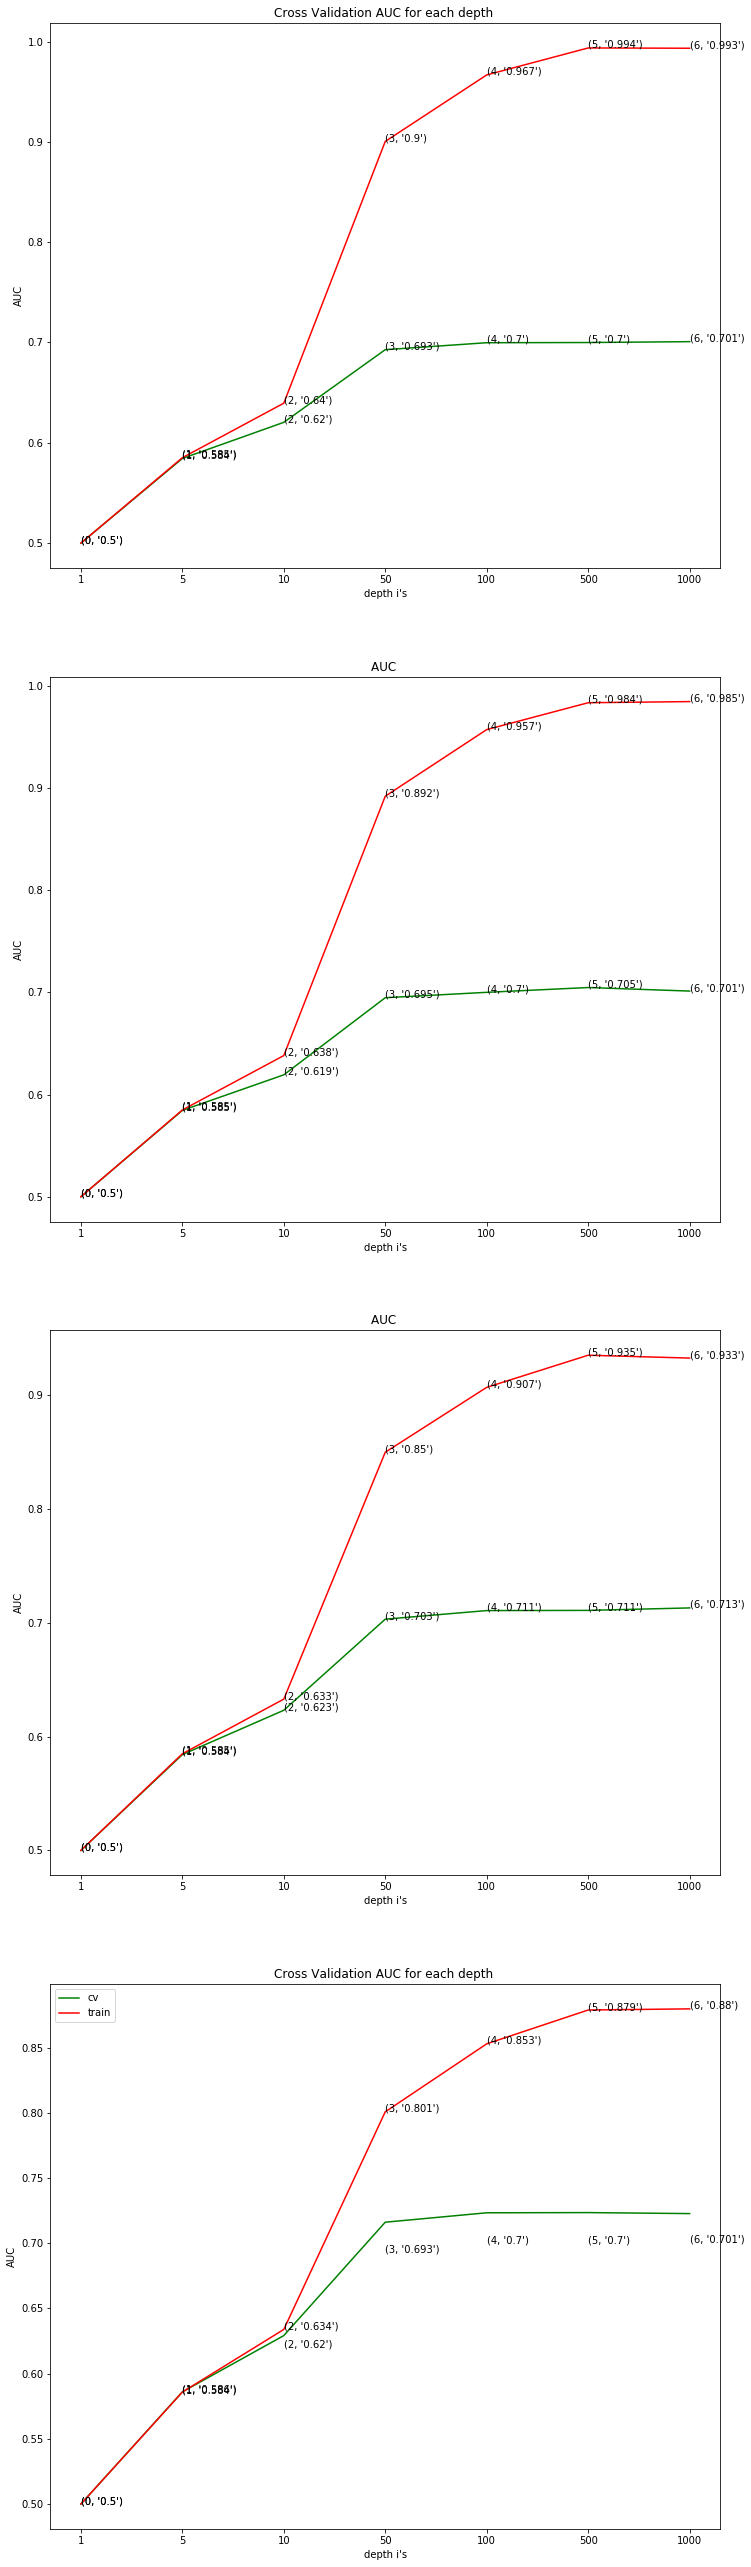

best depth = 500 and min_samples_split = 500


In [91]:
best_depth,best_samples_split = draw(auc_array,auc_array_train)

-------------------- Confusion matrix --------------------


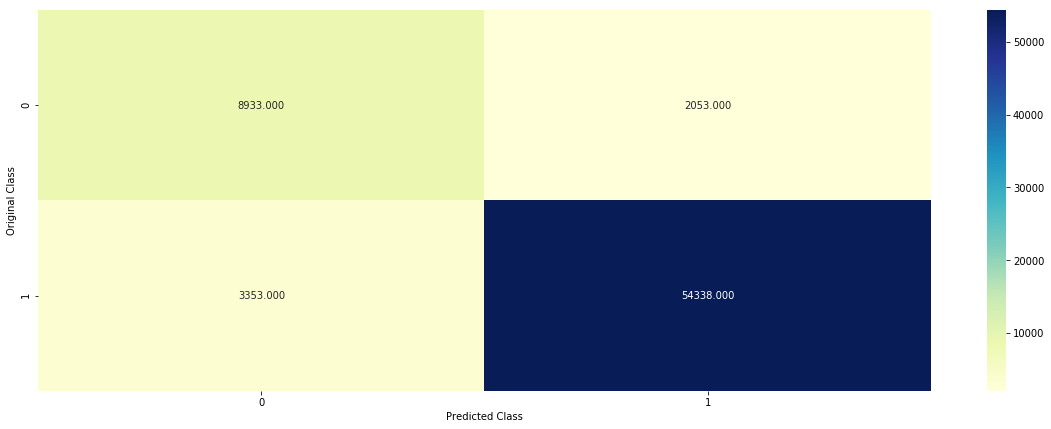

For values of best alpha =  500 The AUC is: 0.8775029062076302
For values of best alpha =  500 The AUC is: 0.7239886990354689
-------------------- Confusion matrix --------------------


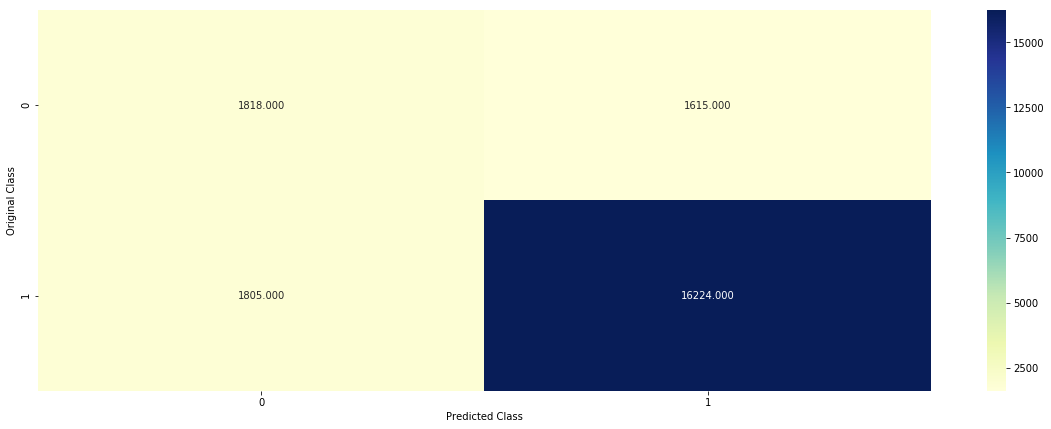

For values of best alpha =  500 The AUC is: 0.7147247491366508


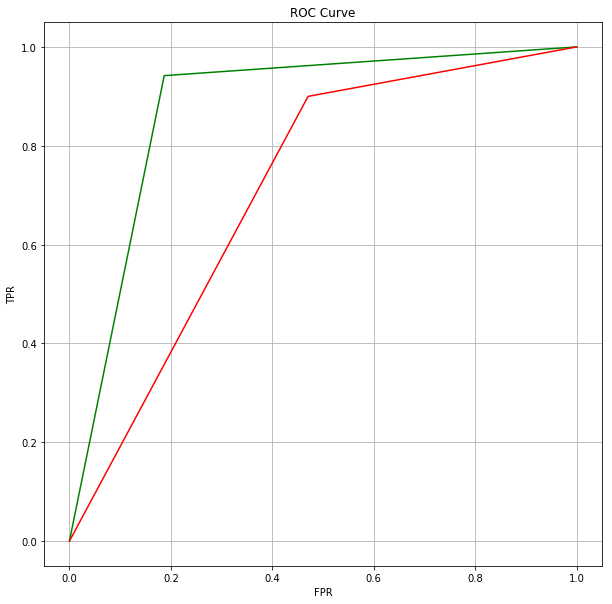

In [92]:
clf = bestModel(train,cv,test,best_depth,best_samples_split)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [94]:
feature_names = tf_idf_vect.get_feature_names()
indices = np.argsort(-clf.feature_importances_)
word_indices = indices[-10:]
word_list = getImportantFeatures(word_indices,feature_names)
print(word_list)

['good at', 'good as when', 'good as what', 'good as well', 'good as this', 'good as they', 'good as the', 'good as starbucks', 'good bargain', 'zukes']


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [97]:
# Please write all the codeindices = np.argsort(-clf.feature_importances_)
word_indices = indices[:10]
word_list = getImportantFeatures(word_indices,feature_names)
print(word_list)

['not', 'great', 'worst', 'disappointed', 'awful', 'was', 'horrible', 'bad', 'threw', 'return']


### [5.2.3] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [100]:
# Please write all the code# words in each node of decision tree
feature = clf.tree_.feature
words = getImportantFeatures(feature,feature_names)
print(len(words))

3173


In [102]:
print(words[:20])

['not', 'worst', 'disappointed', 'awful', 'bad', 'threw', 'horrible', 'great', 'waste', 'terrible', 'disappointing', 'disappointment', 'return', 'disgusting', 'love', 'the best', 'never buy', 'delicious', 'good', 'beware']


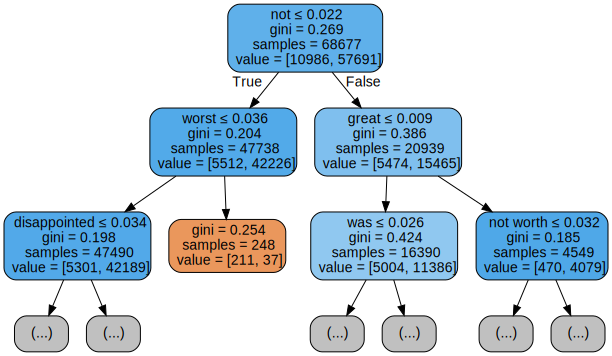

In [104]:
drawTree(clf,feature_names)

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [114]:
train = loadPickleData("avg_w2v_train.pickle")
test = loadPickleData('avg_w2v_test.pickle')
cv = loadPickleData('avg_w2v_cv.pickle')

In [117]:
auc_array,auc_array_train = performHyperParameterTuning(train,cv,test)

for depth = 1 and min_samples_split = 5
Area: 0.5
for depth = 1 and min_samples_split = 10
Area: 0.5
for depth = 1 and min_samples_split = 100
Area: 0.5
for depth = 1 and min_samples_split = 500
Area: 0.5
for depth = 5 and min_samples_split = 5
Area: 0.6336194860870832
for depth = 5 and min_samples_split = 10
Area: 0.6336194860870832
for depth = 5 and min_samples_split = 100
Area: 0.6336194860870832
for depth = 5 and min_samples_split = 500
Area: 0.6336194860870832
for depth = 10 and min_samples_split = 5
Area: 0.6747128046325918
for depth = 10 and min_samples_split = 10
Area: 0.6731526701135975
for depth = 10 and min_samples_split = 100
Area: 0.6674318193135933
for depth = 10 and min_samples_split = 500
Area: 0.6366875339995746
for depth = 50 and min_samples_split = 5
Area: 0.6651029817505466
for depth = 50 and min_samples_split = 10
Area: 0.6652067930067912
for depth = 50 and min_samples_split = 100
Area: 0.6708822752842813
for depth = 50 and min_samples_split = 500
Area: 0.635777576

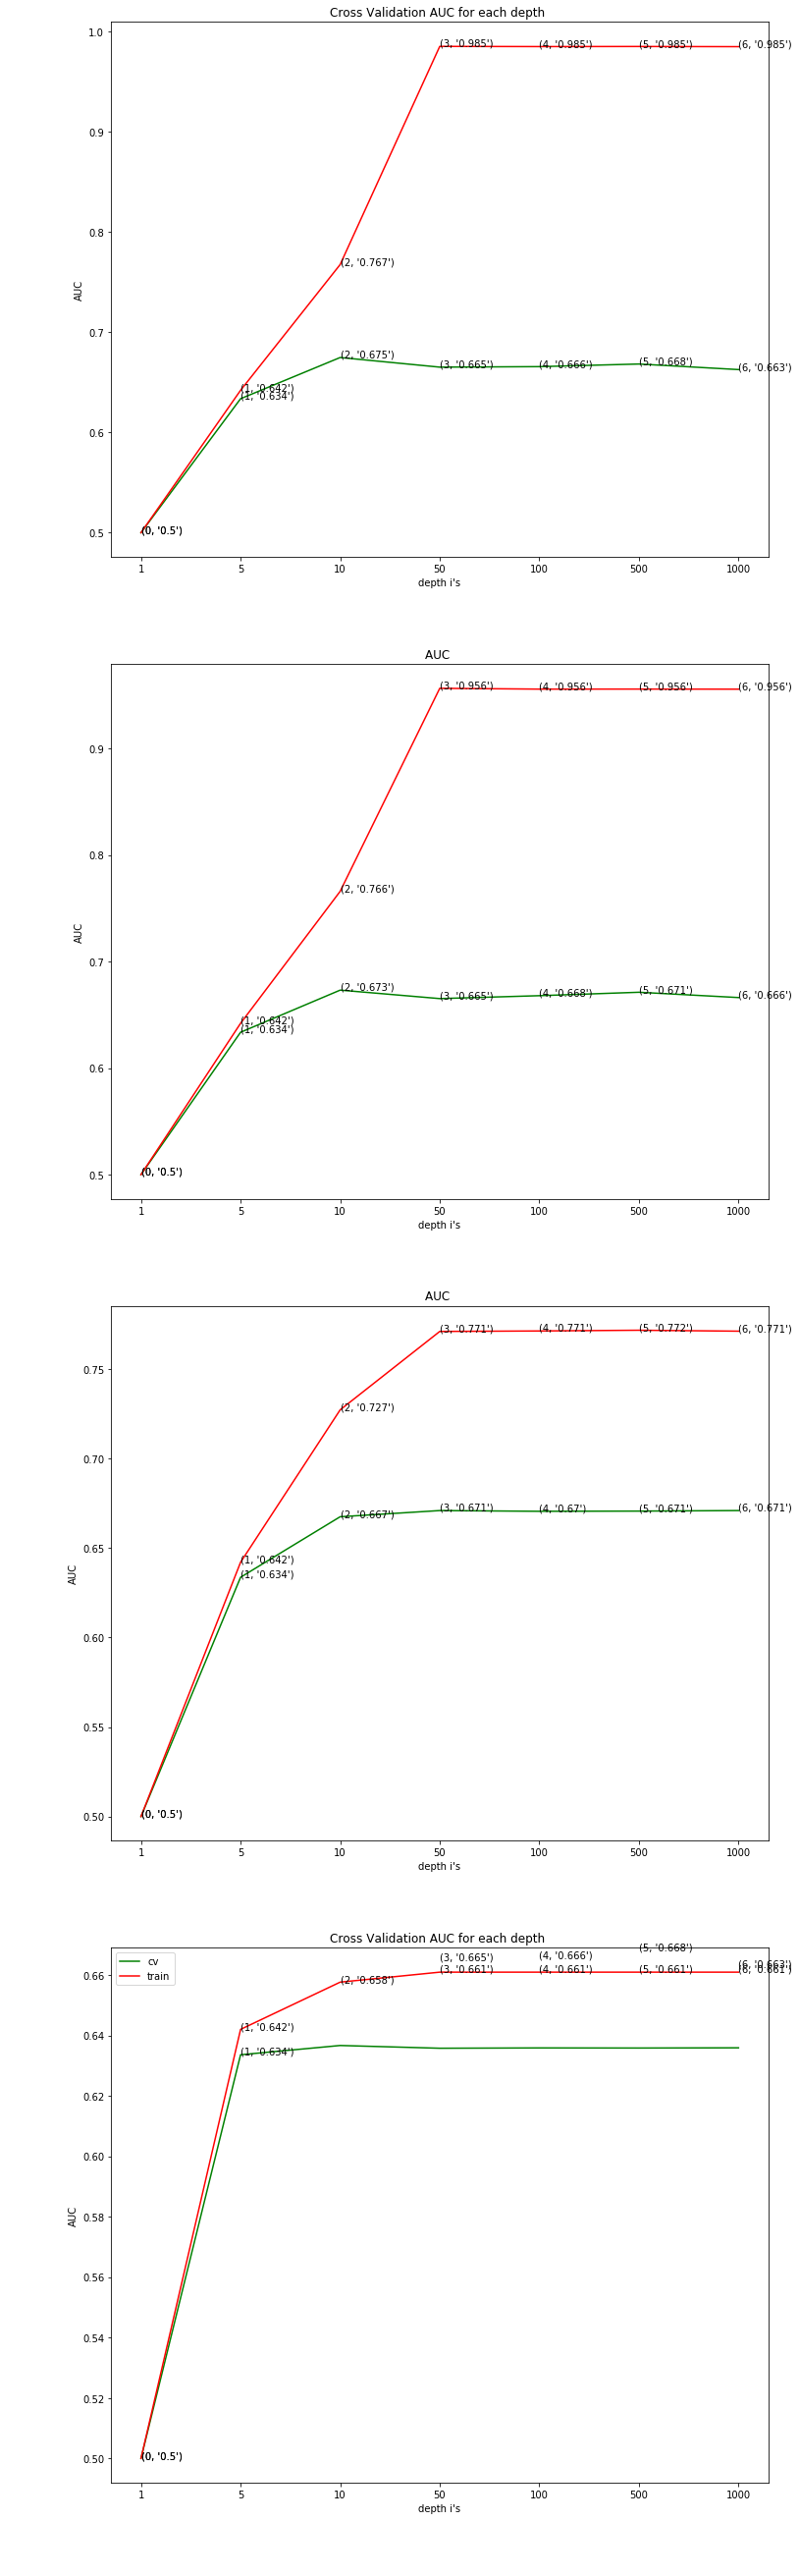

best depth = 10 and min_samples_split = 5


In [118]:
best_depth,best_samples_split = draw(auc_array,auc_array_train)

-------------------- Confusion matrix --------------------


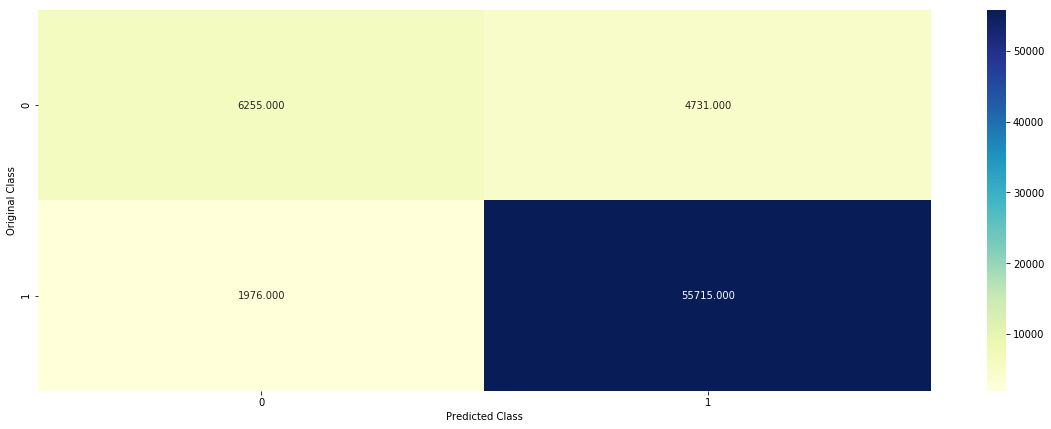

For values of best alpha =  10 The AUC is: 0.767554780941319
For values of best alpha =  10 The AUC is: 0.675154854314544
-------------------- Confusion matrix --------------------


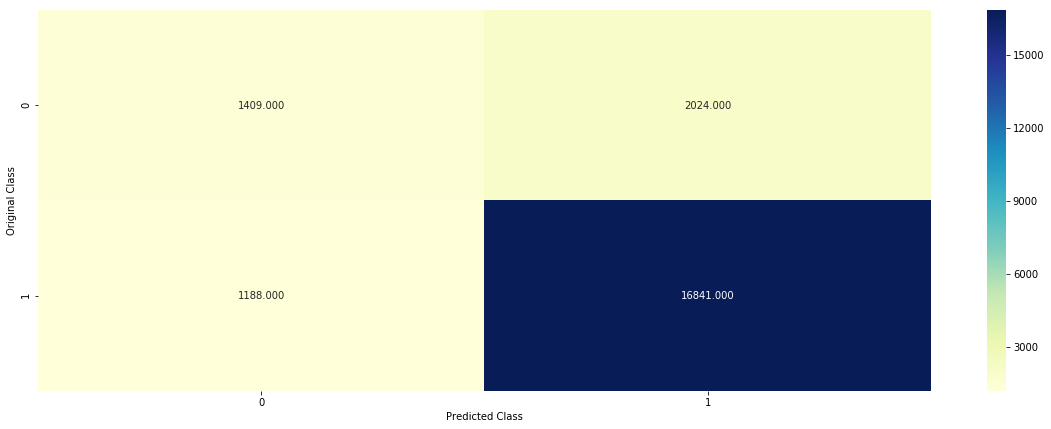

For values of best alpha =  10 The AUC is: 0.6722671796032016


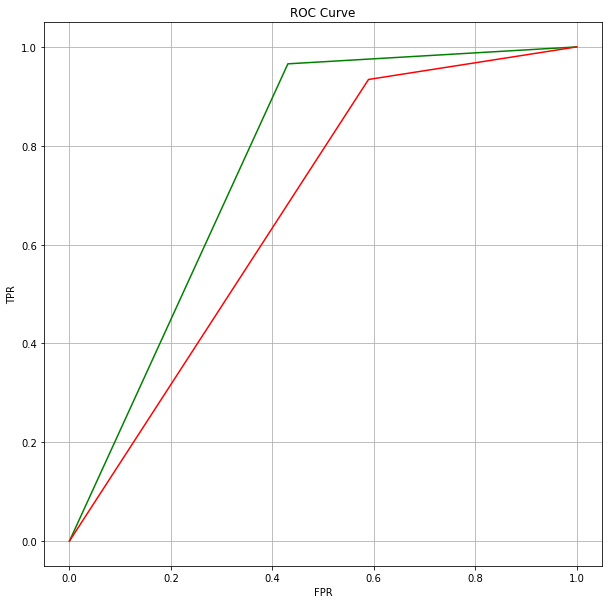

In [120]:
clf = bestModel(train,cv,test,best_depth,best_samples_split)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [128]:
train = loadPickleData("tfidf_w2v_train.pickle")
test = loadPickleData('tfidf_w2v_test.pickle')
cv = loadPickleData('tfidf_w2v_cv.pickle')

In [130]:
auc_array,auc_array_train = performHyperParameterTuning(train,cv,test)

for depth = 1 and min_samples_split = 5
Area: 0.5
for depth = 1 and min_samples_split = 10
Area: 0.5
for depth = 1 and min_samples_split = 100
Area: 0.5
for depth = 1 and min_samples_split = 500
Area: 0.5
for depth = 5 and min_samples_split = 5
Area: 0.5584886575286343
for depth = 5 and min_samples_split = 10
Area: 0.5584886575286343
for depth = 5 and min_samples_split = 100
Area: 0.5584886575286343
for depth = 5 and min_samples_split = 500
Area: 0.5605949053837254
for depth = 10 and min_samples_split = 5
Area: 0.6470634349875131
for depth = 10 and min_samples_split = 10
Area: 0.6467601158112619
for depth = 10 and min_samples_split = 100
Area: 0.6430415123116793
for depth = 10 and min_samples_split = 500
Area: 0.613328676255549
for depth = 50 and min_samples_split = 5
Area: 0.6447780729627306
for depth = 50 and min_samples_split = 10
Area: 0.6479068982895271
for depth = 50 and min_samples_split = 100
Area: 0.6444464347421066
for depth = 50 and min_samples_split = 500
Area: 0.6131987544

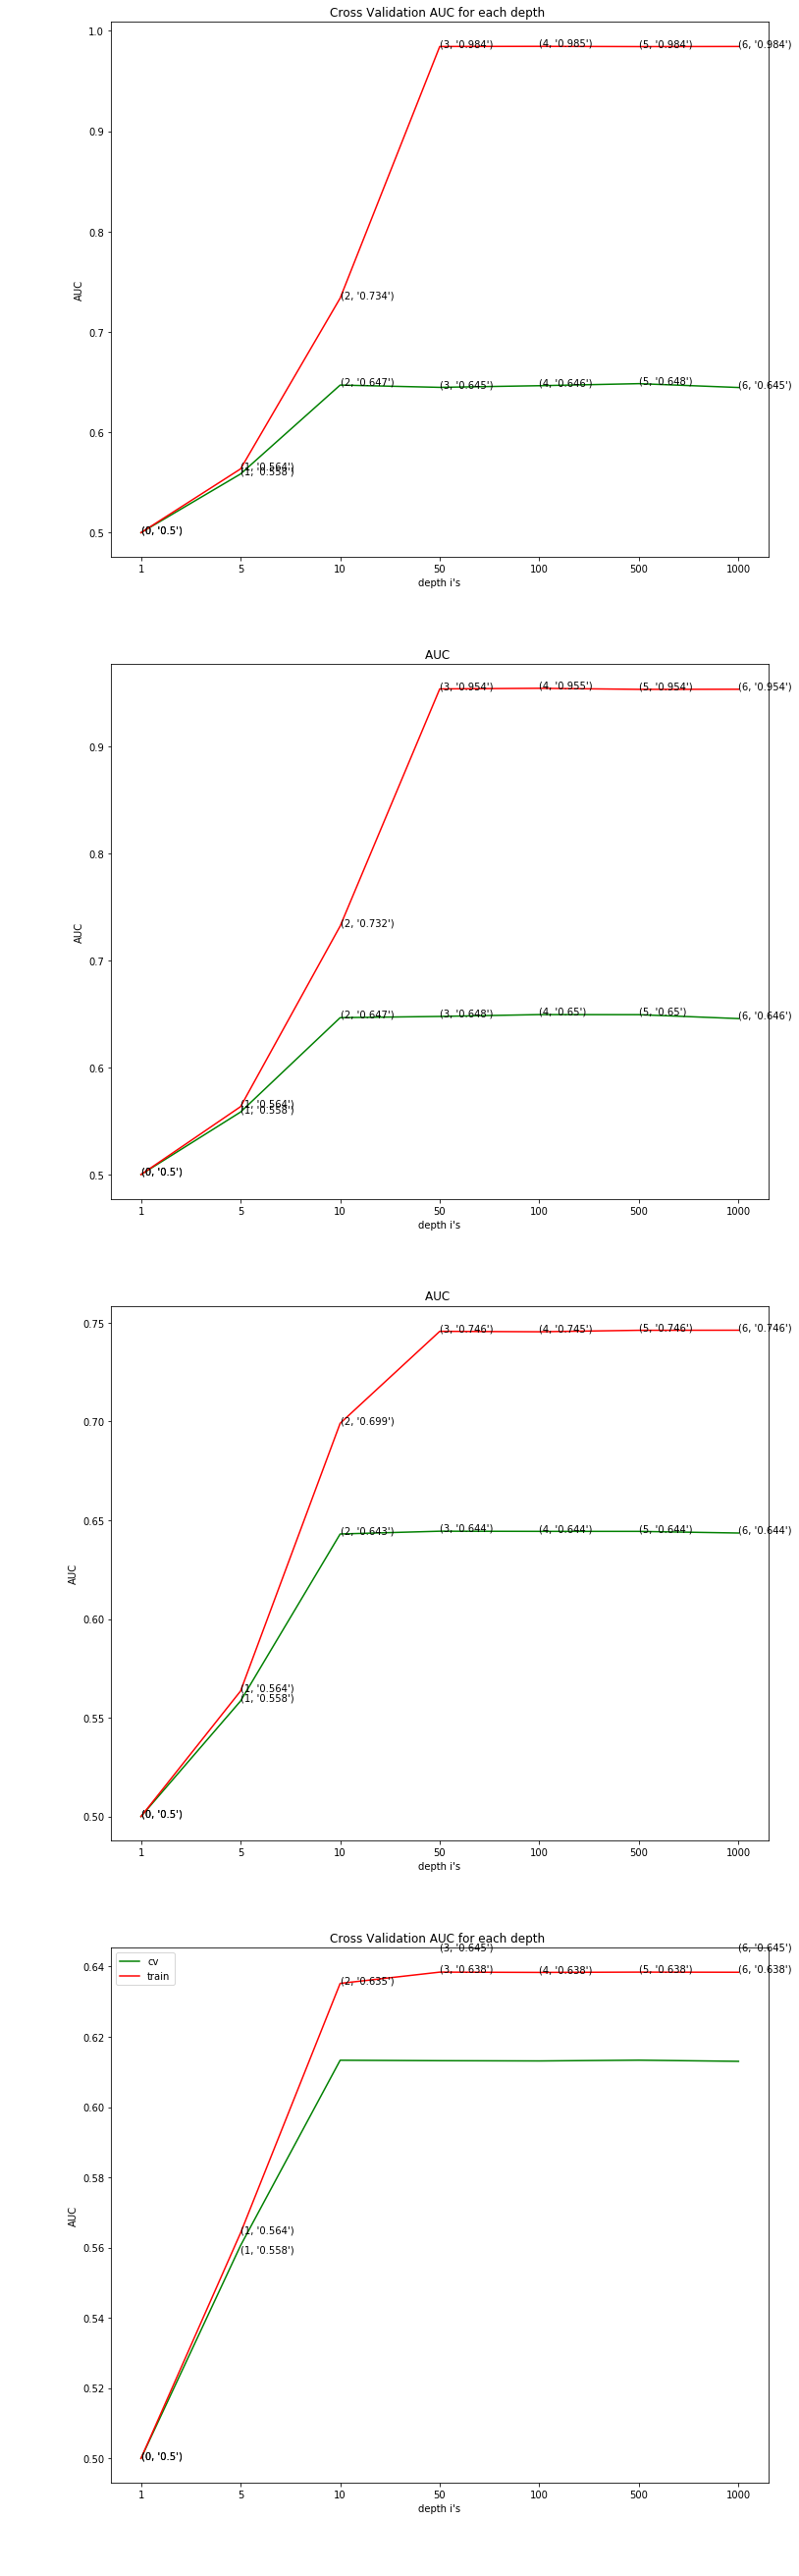

best depth = 100 and min_samples_split = 10


In [131]:
best_depth,best_samples_split = draw(auc_array,auc_array_train)

-------------------- Confusion matrix --------------------


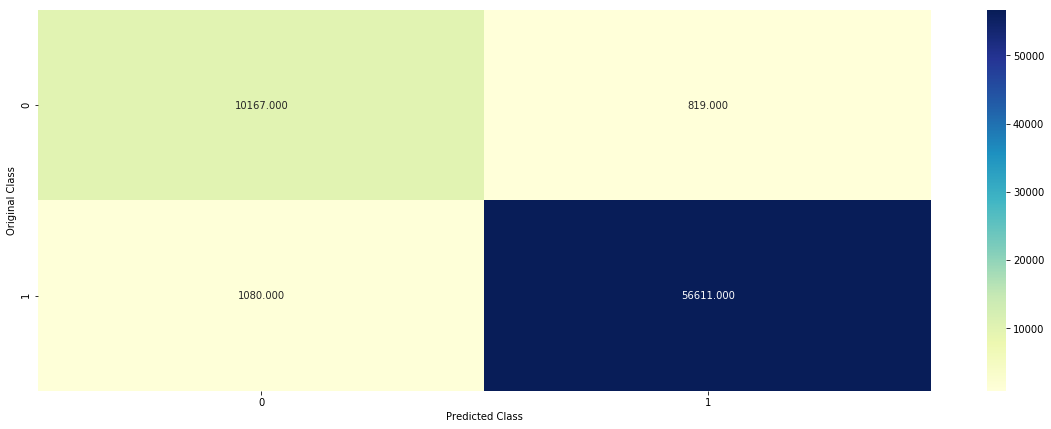

For values of best alpha =  100 The AUC is: 0.9533650745637545
For values of best alpha =  100 The AUC is: 0.6471529731425161
-------------------- Confusion matrix --------------------


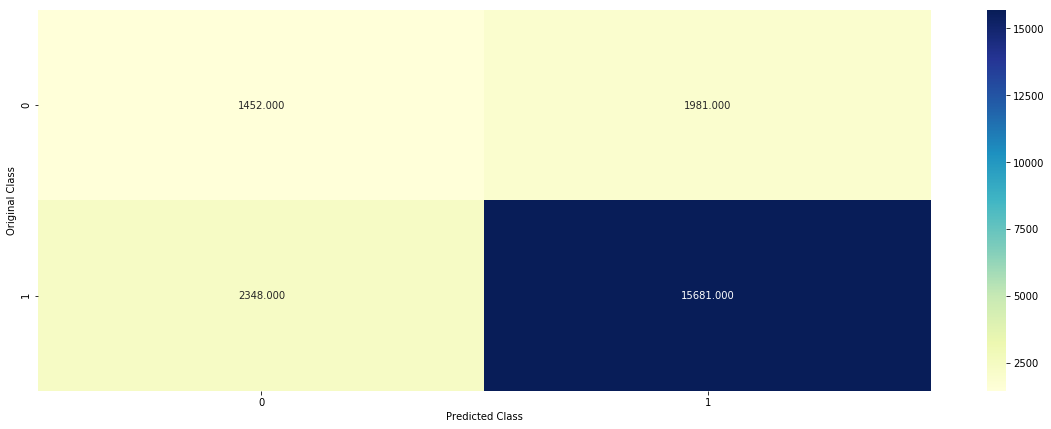

For values of best alpha =  100 The AUC is: 0.6463595314129384


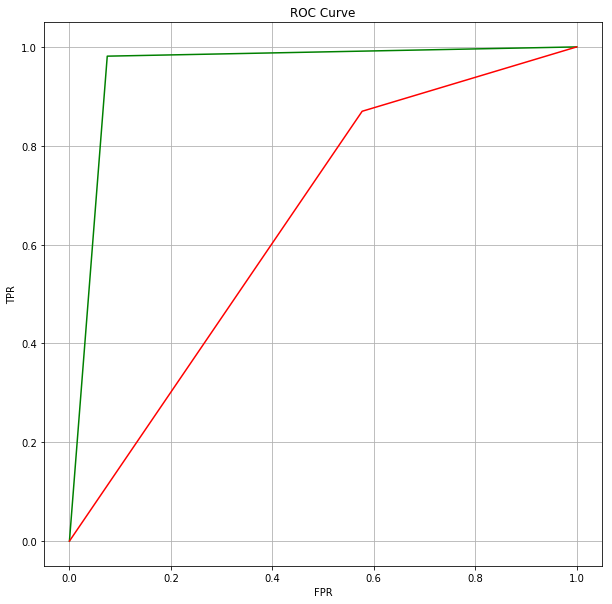

In [132]:
clf = bestModel(train,cv,test,best_depth,best_samples_split)

# [6] Conclusions

| Vectorizer | Depth | min_samples_split | AUC  |
|------------|-------|-------------------|------|
| BOW        | 500   | 500               | 0.70 |
| TFIDF      | 500   | 500               | 0.71 |
| AvgW2V     | 10    | 5                 | 0.67 |
| TFIDFW2V   | 100   | 10                | 0.64 |